# Red Hat Tech Exchange Vienna 2019

## Binary Image Classification Problem

This notebook is a modification of [image_classifier notebook](https://github.com/gsurma/image_classifier).

This notebook trains a model to classify images, in this particular case to classify images into two categories:

* Cats
* Dogs

This notebooks uses an included set of images to train and validate the model. Due to time the notebook uses a reduced set of images.

The results of the model that we will build will not be accurate enough to be used but the goal of the lab is not to build accurrate models but illustrate how OCP and Red Hat Ceph Storage can be used together to run this kind of workloads.

If you want to get an accurate model you can use [this set of images to train the model](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765) (25000 images). Train the model using that set of images took 35 hours using a laptop with a 4-core **Intel(R) Core(TM) i7-4710HQ CPU @ 2.50GHz** (hyperthreading activated).


## Training the model

The first step is to train the model.

You only will have to click in the bellow Cell and press **Shift + Enter** to run the cell.

This will start the model training and you could see two charts:

* Log-loss (cost function)
* Accuracy

You will have to wait until it finishes.

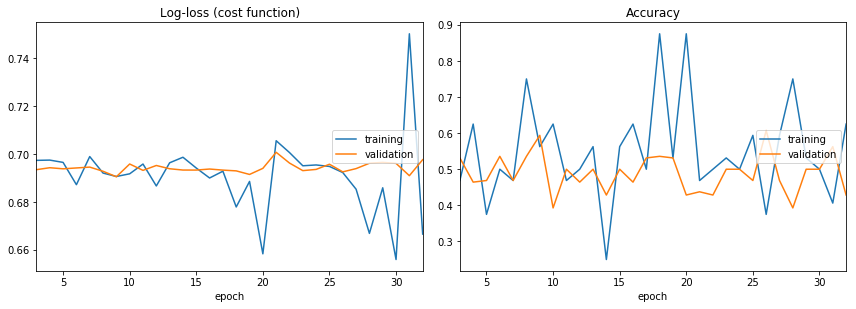

Log-loss (cost function):
training   (min:    0.656, max:    0.750, cur:    0.667)
validation (min:    0.691, max:    0.701, cur:    0.698)

Accuracy:
training   (min:    0.250, max:    0.875, cur:    0.625)
validation (min:    0.393, max:    0.607, cur:    0.429)


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger

GOOGLE_COLAB = False
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "model.h5"

if GOOGLE_COLAB:
    !pip install livelossplot
from livelossplot import PlotLossesKeras

# Data
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/image_classifier/"
training_data_dir = path + "data/training" # 10 000 * 2
validation_data_dir = path + "data/validation" # 2 500 * 2
test_data_dir = path + "data/test" # 12 500

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 32
BATCH_SIZE = 32

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# Model 5
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
    
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
#test_generator = test_data_generator.flow_from_directory(
#    test_data_dir,
#    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
#    batch_size=1,
#    class_mode="binary", 
#    shuffle=False)

# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
#    validation_steps=10,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)
model.save_weights(MODEL_FILE)

# Testing
#open(TEST_FILE,"w")
#probabilities = model.predict_generator(test_generator, TEST_SIZE)
#for index, probability in enumerate(probabilities):
#    image_path = test_data_dir + "/" +test_generator.filenames[index]
#    img = mpimg.imread(image_path)
#    with open(TEST_FILE,"a") as fh:
#        fh.write(str(probability[0]) + " for: " + image_path + "\n")
#    plt.imshow(img)
#    if probability > 0.5:
#        plt.title("%.2f" % (probability[0]*100) + "% dog")
#    else:
#        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
#    plt.show()



if GOOGLE_COLAB:
    files.download(MODEL_SUMMARY_FILE)
    files.download(MODEL_FILE)
    files.download(TRAINING_LOGS_FILE)
    files.download(TEST_FILE)

## Classifying images

After the model is completed we can start to classify images.

To classify images we will send them to a kafka topic and the notebook will get the image to classify from kakfa.

You will have to configure in the below cell:

* kafka topic where images will be read.
* kafka endpoint
* kafka port

The below cell will initialize the kafka consumer that will be used to read images from kafka.

In [26]:
import os

from kafka import KafkaConsumer
from kafka.errors import KafkaError

topic='rhte'

kafkaendpoint = '192.168.100.110'
kafkaport = '9092'

imgfilename = os.path.join(test_data_dir, 'kafka-msg.jpg') 

TEST_SIZE = 1

consumer = KafkaConsumer(topic,
                         bootstrap_servers=[kafkaendpoint + ':' + kafkaport],
                         auto_offset_reset='earliest',
                         enable_auto_commit=True,
                         heartbeat_interval_ms=1000,
                         max_poll_records=1,
                         group_id='test-consumer-group')

## Getting images from kafka

Each time you want to classify an image you will have to:

* Send a image to kafka following the given instructions
* Run the below cell

After reading the image from kafka the image will be classified using the model.

Found 1 images belonging to 1 classes.


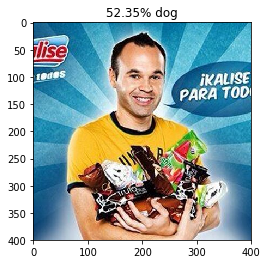

W0725 19:27:50.692603 139935549650688 base.py:971] Heartbeat poll expired, leaving group


In [34]:
consumer.poll()

for message in consumer:
  message = message.value
  fd = open(imgfilename,'wb')
  fd.write(message)
  fd.close()
  break

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

# Testing
open(TEST_FILE,"w")
probabilities = model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    with open(TEST_FILE,"a") as fh:
        fh.write(str(probability[0]) + " for: " + image_path + "\n")
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

## Stopping the consumer

To stop the consumer you only need to run the below cell.

In [24]:
consumer.unsubscribe()
consumer.close()

W0725 19:13:11.236438 139936988882560 base.py:698] Marking the coordinator dead (node 0) for group test-consumer-group: Node Disconnected.


## Challenges

This notebook has the disadvantage that if you want to change the images to train and validate the model you will have to build a new container image including the new set of images.

We can use Red Hat Ceph Storage to fix that.

We can read the training set and validation sets from S3 buckets.

* Cat set for training will have to be stored in __data/training/cat__ directory.
* Dog set for training will have to be stored in __data/training/dog__ directory.
* Cat set for validation will have to be stored in __data/validation/cat__ directory.
* Dog set for validation will have to be stored in __data/validation/dog__ directory.